In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from datetime import datetime
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [3]:
#tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0])

In [4]:
#tf.config.list_physical_devices('GPU')

In [5]:
#!nvidia-smi

In [6]:
#!export CUDA_VISIBLE_DEVICES=0

In [7]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [8]:
fall_csv = os.path.join(os.getcwd(), r"accel_fall_new - Sheet1.csv")
no_fall_csv = os.path.join(os.getcwd(), r"accel_nofall_new - Sheet1.csv")
fall_df = pd.read_csv(fall_csv)
no_fall_df = pd.read_csv(no_fall_csv)

#fall_df.head()

In [9]:
fall_img = os.path.join(os.getcwd(), r"infrared_data\fall")
no_fall_img = os.path.join(os.getcwd(), r"infrared_data\no_fall")
fall_img_files = os.listdir(fall_img)
no_fall_img_files = os.listdir(no_fall_img)


#Function to extract timestamp from filename
def extract_timestamp(filename):
    parts = filename.split()
    month = parts[1]
    day = parts[2]
    timestamp = parts[3]
    return f"{month} {day} {timestamp}"
#Parse and sort filenames chronologically
fall_sorted_filenames = sorted(fall_img_files, key=lambda x: datetime.strptime(extract_timestamp(x), '%b %d %H_%M_%S'))
#Print sorted filenames
#for filename in fall_sorted_filenames:
#    print(filename)
fall_sorted_filenames = [os.path.join(fall_img, item) for item in fall_sorted_filenames]
    
#Parse and sort filenames chronologically
no_fall_sorted_filenames = sorted(no_fall_img_files, key=lambda x: datetime.strptime(extract_timestamp(x), '%b %d %H_%M_%S'))
#Print sorted filenames
#for filename in no_fall_sorted_filenames:
#    print(filename)
no_fall_sorted_filenames = [os.path.join(no_fall_img, item) for item in no_fall_sorted_filenames]

In [10]:
def load_images(filenames):
    image_arrays = []
    for png_file in filenames:
        # Open the image using PIL and convert to NumPy array
        image = Image.open(png_file) 
        image = image.convert('L')

        image_array = np.array(image)
        image_array = np.expand_dims(image_array, axis = 2)
        # Add the image array to the list
        image_arrays.append(image_array)
        # Close the image
        image.close()
    # Create a three-dimensional NumPy array from the list of image arrays
    image_data = np.stack(image_arrays)
    # Print shape of the image data array
    print("Shape of image data array:", image_data.shape)
    return image_data

In [11]:
fall_image_data = load_images(fall_sorted_filenames)
no_fall_image_data = load_images(no_fall_sorted_filenames)

Shape of image data array: (297, 648, 720, 1)
Shape of image data array: (300, 648, 720, 1)


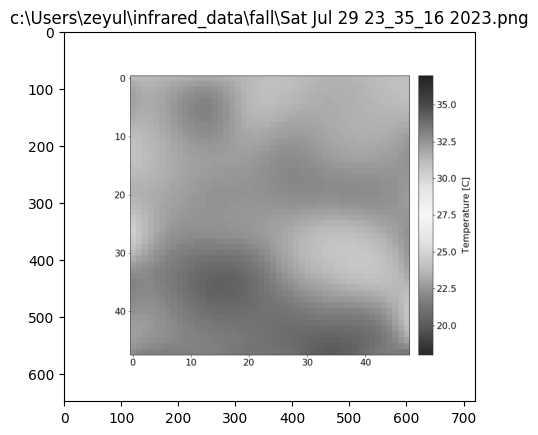

In [12]:
plt.imshow(fall_image_data[0], cmap='gray')
plt.title(fall_sorted_filenames[0])
plt.show()

In [13]:
no_fall_df.shape, fall_df.shape
fall_nan_rows = fall_df[fall_df.isna().any(axis=1)].index

#Find indices of NaN values in columns
fall_nan_columns = fall_df.columns[fall_df.isna().any()]

print("Indices of rows with NaN values:", fall_nan_rows)
print("Indices of columns with NaN values:", fall_nan_columns)

fall_df.loc[fall_nan_rows, fall_nan_columns]

Indices of rows with NaN values: Index([], dtype='int64')
Indices of columns with NaN values: Index([], dtype='object')


""


In [14]:
no_fall_nan_rows = no_fall_df[no_fall_df.isna().any(axis=1)].index

#Find indices of NaN values in columns
no_fall_nan_columns = no_fall_df.columns[no_fall_df.isna().any()]

print("Indices of rows with NaN values:", no_fall_nan_rows)
print("Indices of columns with NaN values:", no_fall_nan_columns)

no_fall_df.loc[no_fall_nan_rows, no_fall_nan_columns]

Indices of rows with NaN values: Index([], dtype='int64')
Indices of columns with NaN values: Index([], dtype='object')


""


In [15]:
no_fall_df['Fall'] = no_fall_df.shape[0]*[0]
fall_df['Fall'] = fall_df.shape[0]*[1]

#fall_df.head()

In [16]:
no_fall_df.shape, fall_df.shape

no_fall_df = no_fall_df.iloc[3:, :]
no_fall_image_data = no_fall_image_data[3:,:,:,:]

In [17]:
all_data = pd.concat([no_fall_df, fall_df], axis = 0)
all_data

,Date,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Fall
3,Sat Jul 29 23:53:33 2023,-0.97,-0.15,-0.57,-0.92,0.05,-0.34,-1.13,-0.08,-0.37,...,-0.37,-0.94,-0.60,-0.15,-0.78,-0.71,-0.17,-0.78,-0.72,0
4,Sat Jul 29 23:54:10 2023,-0.85,-0.09,-0.46,-0.92,-0.15,-0.46,-0.94,-0.10,-0.39,...,-0.25,-0.54,-0.90,-0.23,-0.47,-0.95,-0.24,-0.44,-0.96,0
5,Sat Jul 29 23:54:54 2023,-0.74,-0.10,-0.56,-0.82,-0.12,-0.60,-0.74,-0.15,-0.68,...,-0.56,-0.65,-0.60,-0.56,-0.84,-0.44,-1.31,0.18,-0.57,0
6,Sat Jul 29 23:55:28 2023,-1.04,-0.03,-0.31,-0.78,-0.11,-0.19,-0.83,-0.17,-0.43,...,-0.63,-0.27,0.00,-1.12,-0.19,-0.23,-0.86,-0.29,-0.36,0
7,Sat Jul 29 23:56:49 2023,-0.97,-0.10,-0.44,-0.92,-0.05,-0.54,-1.02,-0.04,-0.34,...,-1.02,-0.11,-0.55,-0.90,-0.16,-0.42,-0.84,-0.04,-0.19,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,Thu Aug 17 23:03:39 2023,-0.74,0.64,-0.07,-0.73,0.65,-0.06,-0.75,0.70,-0.08,...,0.09,1.65,-0.51,0.13,0.99,-0.29,0.13,0.99,-0.27,1
293,Thu Aug 17 23:04:15 2023,-0.21,0.95,0.20,-0.95,0.12,-0.38,-1.20,0.26,-0.56,...,-0.68,0.62,-0.48,-0.50,0.93,-0.27,-0.53,0.84,-0.23,1
294,Thu Aug 17 23:04:36 2023,-0.52,0.81,-0.22,-0.53,0.82,-0.21,-0.55,0.84,-0.17,...,0.02,-0.98,0.07,0.01,-1.00,0.05,0.01,-0.99,0.06,1
295,Thu Aug 17 23:05:13 2023,-0.31,0.92,-0.30,-0.30,0.94,-0.25,-0.34,0.90,-0.20,...,0.40,0.91,0.22,0.39,0.89,0.21,0.38,0.88,0.24,1


In [18]:
X_cols = all_data.columns[1:-1]
X = all_data.loc[:,X_cols].values
Y = all_data.loc[:,"Fall"].values

#X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

#X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state =42)

In [19]:
all_img_data = np.concatenate([no_fall_image_data, fall_image_data], axis = 0)
train_idx, test_idx = train_test_split(np.arange(np.shape(all_data)[0]), test_size = 0.2, random_state = 42)
#train_idx, val_idx = train_test_split(train_idx, test_size = 0.2, random_state = 42)

X_train_acc = X[train_idx, :]
#X_val_acc = X.iloc[val_idx, :]
X_test_acc = X[test_idx, :]
X_train_img = all_img_data[train_idx, :]
#X_val_img = all_img_data[val_idx, :]
X_test_img = all_img_data[test_idx, :]

y_train = Y[train_idx]
#y_val = Y.iloc[val_idx]
y_test = Y[test_idx]

In [20]:
all_img_data.shape

(594, 648, 720, 1)

In [21]:
#Define input shapes
image_input_shape = all_img_data[0].shape
accelerometer_input_dim = X_train_acc.shape[1]

#Define the CNN model architecture

def create_cnn_model(input_shape):
    input_image = Input(shape=input_shape, name='image_input')  
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_image)  
    x = MaxPooling2D((2, 2))(x)  
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)  
    x = MaxPooling2D((2, 2))(x)  
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)  
    x = MaxPooling2D((2, 2))(x)  
    x = Flatten()(x)  
#Create an accelerometer input layer  
    input_accelerometer = Input(shape=(accelerometer_input_dim,), name='accelerometer_input')
#Concatenate the output of the CNN layers with the accelerometer input  
    concatenated = Concatenate()([x, input_accelerometer])  
#Dense layers  
    x = Dense(128, activation='relu')(concatenated)  
    x = Dense(64, activation='relu')(x)  
    output = Dense(1, activation='sigmoid')(x)  # Binary classification output  
    model = Model(inputs=[input_image, input_accelerometer], outputs=output)  
    return model  


#Create the CNN model
model = create_cnn_model(input_shape=image_input_shape)

In [24]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      1.4.0
anyio                        3.6.2
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
asttokens                    2.1.0
astunparse                   1.6.3
attrs                        22.1.0
Babel                        2.11.0
backcall                     0.2.0
beautifulsoup4               4.11.1
bleach                       5.0.1
cachetools                   5.3.1
certifi                      2022.9.24
cffi                         1.15.1
charset-normalizer           2.1.1
colorama                     0.4.6
cvxpy                        1.2.2
cycler                       0.11.0
debugpy                      1.6.3
decorator                    5.1.1
defusedxml                   0.7.1
deprecation                  2.1.0
ecos                         2.0.10
entrypoints                  0.4
executing                    1.2.0
fastjsonschema               2.16.2
f

You should consider upgrading via the 'c:\users\zeyul\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [33]:
!pip install pydotplus



  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24591 sha256=e74cbfb716e0980451bd6b2e391ca9ec6b0d61f47dd8f96ed9e5447407d140e4
  Stored in directory: c:\users\zeyul\appdata\local\pip\cache\wheels\fe\cd\78\a7e873cc049759194f8271f780640cf96b35e5a48bef0e2f36
Successfully built pydotplus


You should consider upgrading via the 'c:\users\zeyul\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [36]:
import pydot
import graphviz
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [35]:
import pydot 
import graphviz

input = tf.keras.Input(shape=(100,), dtype='int32', name='input')  
x = tf.keras.layers.Embedding(  
    output_dim=512, input_dim=10000, input_length=100)(input)  
x = tf.keras.layers.LSTM(32)(x)  
x = tf.keras.layers.Dense(64, activation='relu')(x)  
x = tf.keras.layers.Dense(64, activation='relu')(x)  
x = tf.keras.layers.Dense(64, activation='relu')(x)  
output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(x)  
model = tf.keras.Model(inputs=[input], outputs=[output])  
dot_img_file = '/tmp/model_1.png'  
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True) 

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
#Define the CNN model architecture

def create_cnn_model(input_shape):
    input_image = Input(shape=input_shape, name='image_input')  
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_image)  
    x = MaxPooling2D((2, 2))(x)  
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)  
    x = MaxPooling2D((2, 2))(x)  
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)  
    x = MaxPooling2D((2, 2))(x)  
    x = Flatten()(x)  
#Create an accelerometer input layer  
    input_accelerometer = Input(shape=(accelerometer_input_dim,), name='accelerometer_input')
#Concatenate the output of the CNN layers with the accelerometer input  
    concatenated = Concatenate()([x, input_accelerometer])  
#Dense layers  
    x = Dense(128, activation='relu')(concatenated)  
    x = Dense(64, activation='relu')(x)  
    output = Dense(1, activation='sigmoid')(x)  # Binary classification output  
    model = Model(inputs=[input_image, input_accelerometer], outputs=output)  
    return model  


#Define input shapes
image_input_shape = all_img_data[0].shape
accelerometer_input_dim = X_train_acc.shape[1]

#Create the CNN model
model = create_cnn_model(input_shape=image_input_shape)

#Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
num_epochs = 100
batch_size = 16
# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#Train the model
history = model.fit(
[X_train_img, X_train_acc],  # Provide both image and accelerometer data  
y_train,  #Your binary classification labels  
epochs=num_epochs,  
batch_size=batch_size,  
validation_split=0.3, # You can adjust the validation split as needed  
callbacks = [reduce_lr, early_stopping]
)

Epoch 1/100
21/21 [==============================] - 73s 3s/step - loss: 199.8557 - accuracy: 0.5331 - val_loss: 1.6260 - val_accuracy: 0.5105 - lr: 0.0010
Epoch 2/100
21/21 [==============================] - 69s 3s/step - loss: 0.7499 - accuracy: 0.5693 - val_loss: 0.6274 - val_accuracy: 0.6294 - lr: 0.0010
Epoch 3/100
21/21 [==============================] - 68s 3s/step - loss: 0.5973 - accuracy: 0.7259 - val_loss: 0.5872 - val_accuracy: 0.6643 - lr: 0.0010
Epoch 4/100
21/21 [==============================] - 69s 3s/step - loss: 0.5395 - accuracy: 0.7500 - val_loss: 0.4867 - val_accuracy: 0.8462 - lr: 0.0010
Epoch 5/100
21/21 [==============================] - 67s 3s/step - loss: 0.4388 - accuracy: 0.8313 - val_loss: 0.3668 - val_accuracy: 0.9371 - lr: 0.0010
Epoch 6/100
21/21 [==============================] - 68s 3s/step - loss: 0.3566 - accuracy: 0.8855 - val_loss: 0.3487 - val_accuracy: 0.8741 - lr: 0.0010
Epoch 7/100
21/21 [==============================] - 68s 3s/step - loss: 0

In [21]:
#Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [ ]:
y_pred = model.predict([X_test_img, X_test_acc])
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

In [ ]:
k_vec = [1,3,5,7,9,11,13,15,17,21]
best_acc = 0
best_k = "dogs"
for k in k_vec: 
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, y_train)
    y_pred = knn_classifier.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    if accuracy > best_acc:
        best_acc = accuracy
        best_k = k

        
print("The best value of k is: ", best_k)

knn_classifier = KNeighborsClassifier(n_neighbors=best_k)
knn_classifier.fit(X_train, y_train)
y_pred = knn_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

The best value of k is:  5
Accuracy: 0.9416666666666667

Confusion Matrix:
[[47  6]
 [ 1 66]]

Classification Report:
              precision    recall  f1-score   support

           1       0.98      0.89      0.93        53
           2       0.92      0.99      0.95        67

    accuracy                           0.94       120
   macro avg       0.95      0.94      0.94       120
weighted avg       0.94      0.94      0.94       120

